# Spectrum analysis with Gammapy (run pipeline)

In this tutorial we will learn how to perform a 1d spectral analysis.

We will use a "pipeline" or "workflow" class to run a standard analysis. If you're interested in implementation detail of the analysis in order to create a custom analysis class, you should read ([spectrum_analysis.ipynb](spectrum_analysis.ipynb)) that executes the analysis using lower-level classes and methods in Gammapy. 

In this tutorial we will use the folling Gammapy classes:

- [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html) to load the data to 
- [gammapy.scripts.SpectrumAnalysisIACT](http://docs.gammapy.org/en/latest/api/gammapy.scripts.SpectrumAnalysisIACT.html) to run the analysis

We use 4 Crab observations from H.E.S.S. for testing.

## Setup

As usual, we'll start with some setup for the notebook, and import the functionality we need.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from gammapy.data import DataStore
from gammapy.scripts import SpectrumAnalysisIACT

# Convenience classes to define analsys inputs
# At some point we'll add a convenience layer to run the analysis starting from a plain text config file.
from gammapy.utils.energy import EnergyBounds
from gammapy.image import SkyImage
from gammapy.spectrum import models
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord
import astropy.units as u

## Select data

First, we select and load some H.E.S.S. data (simulated events for now). In real life you would do something fancy here, or just use the list of observations someone send you (and hope they have done something fancy before). We'll just use the standard gammapy 4 crab runs.

In [2]:
# TODO: Replace with public data release
store_dir = '$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2'
data_store = DataStore.from_dir(store_dir)
obs_id = data_store.obs_table['OBS_ID'].data
print("Use observations {}".format(obs_id))

obs_list = data_store.obs_list(obs_id)

Use observations [23523 23526 23559 23592]


## Configure the analysis

Now we'll define the input for the spectrum analysis. It will be done the python way, i.e. by creating a config dict containing python objects. We plan to add also the convenience to configure the analysis using a plain text config file.

In [3]:
# on region
crab_pos = SkyCoord.from_name('crab')
on_region = CircleSkyRegion(crab_pos, 0.15 * u.deg)

# fit model
model = models.LogParabola(alpha = 2.3,
                           beta = 0,
                           amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
                           reference = 1 * u.TeV)

# flux points
flux_point_binning = EnergyBounds.equal_log_spacing(0.7, 30, 5, u.TeV)

# exclusion mask
exclusion_mask = SkyImage.read('$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits')

In [4]:
config = dict(
    outdir = None,
    background = dict(on_region=on_region,
                      exclusion_mask=exclusion_mask,
                      min_distance = 0.1 * u.rad,
                      ),
    extraction = dict(containment_correction=False),
    fit = dict(model=model,
               stat='wstat',
               forward_folded=True,
               fit_range = flux_point_binning[[0, -1]]),
    fp_binning=flux_point_binning
)

## Run the analysis

TODO: Clean up the log (partly done, get rid of remaining useless warnings)

In [5]:
ana = SpectrumAnalysisIACT(observations=obs_list,
                                     config=config
                                    )
ana.run()

INFO:gammapy.scripts.spectrum_pipe:Running SpectrumAnalysisIACT
INFO:gammapy.background.reflected:Running ReflectedRegionsBackgroundEstimator
Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    ( 83.6332124,  22.0144601)>
radius: 0.15 deg
ObservationList
Number of observations: 4
Info for OBS_ID = 23523
- Start time: 53343.92
- Pointing pos: RA 83.63 deg / Dec 21.51 deg
- Observation duration: 1687.0 s
- Dead-time fraction: 6.240 %
Info for OBS_ID = 23526
- Start time: 53343.95
- Pointing pos: RA 83.63 deg / Dec 22.51 deg
- Observation duration: 1683.0 s
- Dead-time fraction: 6.555 %
Info for OBS_ID = 23559
- Start time: 53345.96
- Pointing pos: RA 85.25 deg / Dec 22.01 deg
- Observation duration: 1686.0 s
- Dead-time fraction: 6.398 %
Info for OBS_ID = 23592
- Start time: 53347.91
- Pointing pos: RA 82.01 deg / Dec 22.01 deg
- Observation duration: 1686.0 s
- Dead-time fraction: 6.212 %

INFO:gammapy.background.reflected:Processing observation Info for OBS_ID = 2352

## Check out the results

TODO: Nice summary page with all results

In [6]:
print(ana.fit.result[0])


Fit result info 
--------------- 
Model: LogParabola

Parameters: 

	   name     value     error         unit      min  max  frozen
	--------- --------- --------- --------------- ---- ---- ------
	amplitude 2.374e-11 1.807e-12 1 / (cm2 s TeV)    0 None  False
	reference 1.000e+00 0.000e+00             TeV None None   True
	    alpha 1.883e+00 1.770e-01                 None None  False
	     beta 1.853e-01 7.857e-02                 None None  False

Covariance: 

	name/name amplitude  alpha      beta  
	--------- --------- -------- ---------
	amplitude  3.26e-24 2.09e-13 -6.22e-14
	    alpha  2.09e-13   0.0313   -0.0128
	     beta -6.22e-14  -0.0128   0.00617 

Statistic: 26.058 (wstat)
Fit Range: [  0.77426368  27.82559402] TeV



(<matplotlib.axes._subplots.AxesSubplot at 0x7ffb15ccb290>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffb15bdb9d0>)

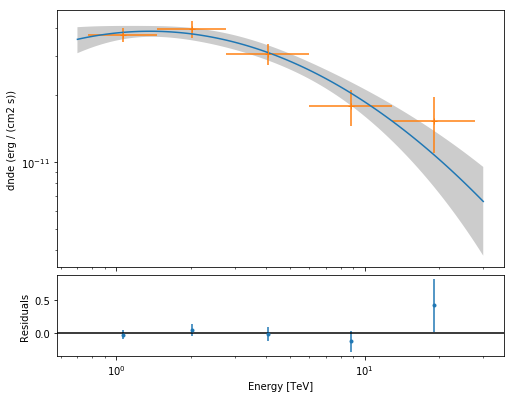

In [8]:
ana.spectrum_result.plot(energy_range=ana.fit.fit_range,
                         energy_power=2, flux_unit='erg-1 cm-2 s-1',
                         fig_kwargs=dict(figsize = (8,8)))